In [0]:
import pandas as pd
import numpy as np
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [3]:
torch.__version__

'1.0.1.post2'

In [3]:
from google.colab import files
uploaded = files.upload()

In [0]:
from google.colab import files
uploaded = files.upload()

Saving Line.txt to Line.txt


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [42]:
sp_text = ""

chars = []
i = 0
for char in open('/content/drive/My Drive/Colab Notebooks/character.txt'):
    chars.append(char.strip() + ":\t")
    if i>=4000:
        break
    i = i+1
lines = [] 

i = 0
for line in open('/content/drive/My Drive/Colab Notebooks/Line.txt', encoding='ISO-8859-1' ):
        lines.append(line)
        if i>=4000:
            break
        i = i+1
        
for i in range(len(lines)):
    total = chars[i] + lines[i]
    sp_text += total
    
vocab = list(set(sp_text))
vocab_stoi = {s: i for i, s in enumerate(vocab)}
vocab_itos = {i: s for i, s in enumerate(vocab)}
print(len(sp_text))
print(vocab_stoi)

292275
{'a': 0, '7': 1, 'R': 2, '6': 3, '!': 4, 'S': 5, 'J': 6, '\n': 7, 'n': 8, 'I': 9, 'h': 10, ':': 11, 'O': 12, 'j': 13, 't': 14, '\ufeff': 15, 'À': 16, 'P': 17, 'r': 18, 'V': 19, '(': 20, '-': 21, 'å': 22, 'b': 23, 'M': 24, 'L': 25, ' ': 26, "'": 27, 'Ì': 28, 'x': 29, 'T': 30, '©': 31, 'G': 32, '0': 33, 'N': 34, 'D': 35, 'e': 36, 'p': 37, 'd': 38, '\t': 39, '4': 40, 'B': 41, '+': 42, '2': 43, 'H': 44, '.': 45, '1': 46, ';': 47, 'g': 48, '#': 49, 'A': 50, '5': 51, 'Q': 52, '¬': 53, 'Á': 54, 'y': 55, ',': 56, 'm': 57, '3': 58, 'U': 59, '$': 60, 'v': 61, '/': 62, 'q': 63, ')': 64, '±': 65, 'C': 66, 'Y': 67, 'c': 68, '&': 69, 's': 70, 'Z': 71, 'K': 72, '9': 73, '"': 74, '%': 75, 'u': 76, '8': 77, 'o': 78, 'X': 79, 'k': 80, '?': 81, 'l': 82, 'W': 83, 'f': 84, 'i': 85, 'w': 86, 'E': 87, 'F': 88, 'z': 89}


In [0]:
import random
random.seed(10)

sp_len = len(sp_text) #get the length of the south park text 

def random_chunk(chunk_len=1000):
    """Return a random subsequence from `spam_text`"""
    start_index = random.randint(0, sp_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return sp_text[start_index:end_index] #gets a random chunk of size chunk len

def text_to_numpy(text, vocab=vocab):  #
    """Return a tensor containing the indices of characters in `text`."""
    indices = [vocab_stoi[ch] for ch in text]
    return np.asarray(indices)

  
example = text_to_numpy(random_chunk())
# print(example)


In [43]:
## based on ideas from https://github.com/thomasxmeng/Project-tv-script-generation-RNN/blob/master/dlnd_tv_script_generation_7.ipynb

def make_data_loader(sp_txt_np, inp_len, batch_size): 
    #create input target sequence pairs 
    length = len(sp_txt_np) #figure out how long the sp_text_np array is
    
    inp_list = []
    target_list = []
    start_ind = 0
    end_ind = inp_len
    tar_ind = inp_len
    
    #we want to return inputs and targets, where inputs are a vector array of sequence length 
    while (length-start_ind)> inp_len: #while we can still create a batch target pair 
      inp_list.append(sp_txt_np[start_ind:end_ind])
      target_list.append(sp_txt_np[tar_ind])
      
      #shift everything by 1
      start_ind +=1
      end_ind +=1
      tar_ind +=1
      
    #convert the inputs and targets into np arrays in order to convert them to torch tensors
    inputs = np.asarray(inp_list)
    targets = np.asarray(target_list)
      
    #create a data loader 
    data = TensorDataset(torch.from_numpy(inputs), torch.from_numpy(targets))
    data_loader = torch.utils.data.DataLoader(data, shuffle=True, batch_size=batch_size) #shuffle and add batch size
   
  # return a dataloader
    return data_loader
  
  
loader = make_data_loader(text_to_numpy(sp_text),30,1)
print(text_to_numpy(sp_text)[:4])
for i,j in loader:
    print(i.type())
    print(i.shape,len(j))
    break

[15  5 14  0]
torch.LongTensor
torch.Size([1, 30]) 1


In [0]:
class Cartmanboi(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1,dropout=0.2):
        super(Cartmanboi, self).__init__()
        # RNN attributes
        self.name = "c1"
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        # identity matrix for generating one-hot vectors on the chars 
        self.ident = torch.eye(vocab_size)
        # recurrent neural network
        self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first=True,dropout=dropout)
        # a fully-connect layer that decodes the RNN output to
        # a distribution over the vocabulary
        self.decoder = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inp, hidden):
        batch_size = inp.size(0) #figure out what the size of the input is 
        # generate one-hot vectors from token indices
        inp = self.ident[inp].cuda()
        # obtain the next output and hidden state
        #print(inp.shape)
        output, hidden = self.rnn(inp, hidden)
        output = self.decoder(output.squeeze(0))
        output = output.view(batch_size, -1, self.vocab_size)

        output = output[:,-1] #take the last output 
        return output, hidden

    def init_hidden(self,batch_size): #this returns a hidden size the same size as the batch size 
        return torch.zeros(self.n_layers, batch_size, self.hidden_size).cuda()

In [0]:
def get_model_name(name, batch_size, learning_rate, epoch,hidden_size, layers):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    model_name = 'model_{0}_bs{1}_lr{2}_epoch{3}_h{4}_l{5}'.format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch,
                                                   hidden_size, layers)
    path = F"/content/drive/My Drive/Colab Notebooks/{model_name}"
    return path

In [0]:
device = torch.device('cuda:0')

In [0]:
def evaluate(model, prime_str='Kyle:', sq_length=30, predict_len=500, temperature=0.8):
    hidden = model.init_hidden(1) #create a hidden layer the size of our prime string 
    prime_input = text_to_numpy(prime_str) #convert out prime string to a np array vector 
    
    
    #create a matrix the same size as our input batches 
    current_seq = np.full((1, sq_length), vocab_stoi[" "]) #create a vector to hold the predicted characters 
    
    current_seq[-1][len(current_seq)-len(prime_input)-1:] = prime_input
    predicted = prime_str #predicted holds the predicted sequence 
    current_seq = torch.from_numpy(current_seq)
#     model.cuda()
    for p in range(predict_len):  #for however many characters we want to predict 
        current_seq = torch.LongTensor(current_seq).cuda() #turn our current sequence into a long tensor 
        output, hidden = model(current_seq, hidden)
#         print(hidden.shape)
#         print(current_seq.shape)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted character to string and use as next input
        predicted_char = vocab_itos[top_i] #figure out what the predicted character is
        predicted += predicted_char
        
#         print(current_seq)
        current_seq = np.roll(current_seq.cpu(), -1, 1)
#         print(current_seq)
        current_seq[-1][-1] = top_i
#         print(current_seq)

    return predicted

def train(model, num_epochs=50, batch_size = 128, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    #convert the text into a vector aray, how many previous chars to use for prediction, the size of the batch
    train_loader =  make_data_loader(text_to_numpy(sp_text),30,batch_size) 
    model.cuda()
    
    losses = []
    epochs = []

    for epoch in range(num_epochs):
        hidden = model.init_hidden(batch_size)
        for inp,tar in train_loader: #note that we don't have a validation loader 
            if len(tar) == batch_size:
#                 hidden =hidden.type(torch.cuda.LongTensor)
#                 print(hidden.type())
                inp, tar = inp.cuda(), tar.cuda()
#                 print(inp.type())
                optimizer.zero_grad()
                output,_ = model(inp,hidden)
                loss = criterion(output, tar)
                loss.backward()
                optimizer.step() 
        losses.append(float(loss))
        epochs.append(epoch)

        print("[Epoch %d] Loss %f" % (epoch+1, float(loss)))
        model_path = get_model_name(model.name, batch_size, lr, epoch,model.hidden_size,model.n_layers)
        torch.save(model, model_path)
        print(evaluate(model,prime_str="Kyle:"))
        
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()



In [0]:
model = Cartmanboi(len(vocab),256,2)
train(model,num_epochs=50,batch_size=128, lr=0.002)

In [0]:
model = Cartmanboi(len(vocab),256,2)
train(model,num_epochs=20,batch_size=64, lr=2e-4)

[Epoch 1] Loss 2.195180


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Cartmanboi. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Kyle:	Mrtaralist anous ou akithistod ane go whot atleme someny the seres? 
Calnmw:	1ine home Ms Garenem Shot wand ather to were!  
Cann:	Wooll'y rep foplo geveris of it ane ae doons the ave lis hicponareire yousse thie wam, bess he hame? I'd de hit hich!  
Ctan:	Ceallen Ol mutard other you tore tho here the as there. 
Kyle:	Ot ar. 
Kllle:	Ok. 
Ay!:	Tout s at deke the! . whout gay sinas. 
Depissa:	Hes fouling on it fare sher scene tore sans site ot shocl, np an am ot? 
Me. I doin ly ites g'e manlimy A
[Epoch 2] Loss 1.951931
Kyle:. He goine ta macp pestout fond stene peick fore sow think betebing one I mesa to get to to can that. I mave and an soo to pid to let sid to fan to have a capelmed in to sthare nove hese be the card and on all cake to stis!  
Butters:	Butt rist you gut wis that are he rust it to kabe wo like you ray make. 
Cartming:	And to cnot the raking cuser you wack- Mamber you mant and thand to not gome. 
Kyle:	Yaig his the hall to meve nofling te ta th on just rest and th

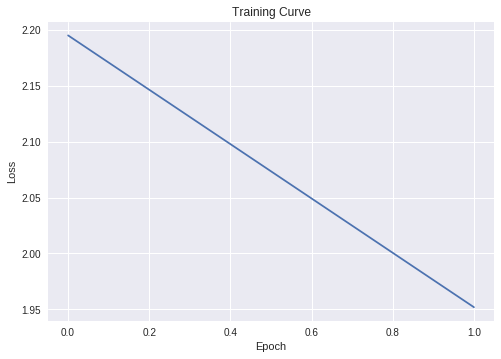

In [54]:
model_1 = Cartmanboi(len(vocab),256,2)
train(model_1,num_epochs=2,batch_size=128, lr=2e-4)

**Evaluation Section**




In [0]:
def evaluate(model, prime_str='Kyle:', sq_length=30, predict_len=500, temperature=0.8):
    hidden = model.init_hidden(1) #create a hidden layer the size of our prime string 
    prime_input = text_to_numpy(prime_str) #convert out prime string to a np array vector 
    
    
    #create a matrix the same size as our input batches 
    current_seq = np.full((1, sq_length), vocab_stoi[" "]) #create a vector to hold the predicted characters 
    
    current_seq[-1][len(current_seq)-len(prime_input)-1:] = prime_input
    predicted = prime_str #predicted holds the predicted sequence 
    current_seq = torch.from_numpy(current_seq)
    model.cuda()
    for p in range(predict_len):  #for however many characters we want to predict 
        current_seq = torch.LongTensor(current_seq).cuda() #turn our current sequence into a long tensor 
        output, hidden = model(current_seq, hidden)
#         print(hidden.shape)
#         print(current_seq.shape)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted character to string and use as next input
        predicted_char = vocab_itos[top_i] #figure out what the predicted character is
        predicted += predicted_char
        
#         print(current_seq)
        current_seq = np.roll(current_seq.cpu(), -1, 1)
#         print(current_seq)
        current_seq[-1][-1] = top_i
#         print(current_seq)

    return predicted

In [55]:
##Get the best model
net = Cartmanboi(len(vocab),256,2)
model_path = get_model_name(net.name, 128, 0.0002, 1,256,2)
net = torch.load(model_path)
print(evaluate(net.eval(),prime_str = "Cartman:"))

Cartman:	Bift in, the wall of this in a s wisp ever the Prigst peesss. 
Clarma:	Yeag, not?! 
Kyle:	You just canking his goid get and mocheral to got you seel a soper go te werp on to metes and matter, me tuis the got a bud to re stime it to me hall to kavo at hamp en't wake heveara onta pore, to mad the tar fort poare you bust the Wan war andust.  Jether. 
Bistori:	All howiss, whit?  Harlist theved foot you keen to giss five to have to cokn of all bant ant he just I hang tamaratte tot to we thet right? 
